In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit, prange

import tables
import os

cs137_co60.h5 (File) ''
Last modif.: 'Sun Sep 30 12:17:15 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(83439,), shuffle, zlib(1)) ''
/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''

83439


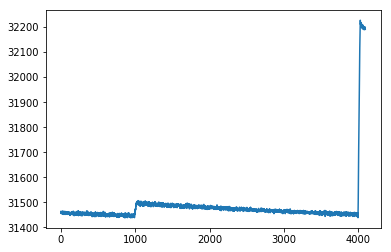

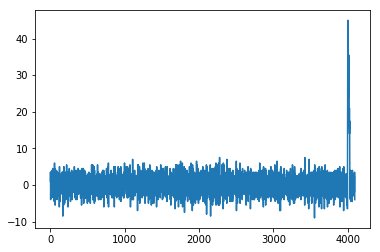

In [48]:
h5file = tables.open_file("cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData
print(len(EventData))



plt.figure()
plt.plot(data[2422,:])
plt.figure()
plt.plot(np.gradient(data[2422,:]))
plt.show()

In [53]:
# Find pulses that triggered multiple times and delete them
i_pileup = 0
j_pileup = 0
pileup_args = np.array([])
EventDataArray = np.array(EventData)

for x in range(len(EventData)):
    if int(EventData[x][3])>1:
        pileup_args = np.append(pileup_args,i_pileup)
        j_pileup = j_pileup+1  
    i_pileup = i_pileup+1

print(data)
print(len(pileup_args))

data = np.delete(data[:], pileup_args, 0)
    
print('deleted ', len(pileup_args),' signals due to pile up')
print(len(data2))

/RawData (EArray(83439, 4096), shuffle, zlib(1)) ''
999


/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  app.launch_new_instance()


deleted  999  signals due to pile up
82440


In [277]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [280]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):
#    GradSignal = np.gradient(mysignal)
#    argPeak = np.argmax(GradSignal)
#    avgNoise = np.mean(mysignal[0:1000])
    signalOnly = baseLineReduction(mysignal) 
#    
#    @jit(parallel = True)
#    def func(x, a, b):
#        return a * np.exp(-b * x)
#
#    popt, pcov = curve_fit(func, range(0,len(newSignal)-argPeak), newSignal[argPeak:])
#    tau = 1/popt[1]
    
    #signalOnly = newSignal[argPeak:]
#    signalOnly = newSignal
    m=40
    #k=int((len(signalOnly)-m)/2)
    #k = peaking time
    #m= Gap time (in samples)
    k=100
    M = tau
    Acc1=0.0
    Acc2=0.0
#    l =2*k+m
#    final = list(range(len(signalOnly)))
    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)/(2.0*k+M)
    #/max(final)
    return normFinal

In [159]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals = makesignals(data)

print(datetime.now() - startTime)

82440
0:00:05.145184


In [263]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [287]:

#tau = np.zeros(events)
#trap_out = np.zeros((events,cols))

@jit(parallel = True)
def eventsProcess(mysignals, events, cols):
    tau = np.zeros(events)
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
#        print(j)
#        mysignal = mysignals[j,:]
#        GradSignal = np.gradient(mysignal)
#        argPeak = np.argmax(GradSignal)
#        avgNoise = np.mean(mysignal[0:900])
#        newSignal = mysignal - avgNoise
    #    plt.figure()
    #    plt.plot(newSignal)

#        @jit(parallel = True)
#        def func(x, a, b):
#            return a * np.exp(-b * x)

        popt, pcov = curve_fit(func, range(0,len(newSignal)-1050), newSignal[1050:])
    #    print(popt)
        tau[j] = 1.0/popt[1]
        trap_out[j] = TrapFilter(mysignals[j,:],5400.0)
    print('Average Tau across all signals',np.mean(tau))
    print(datetime.now() - startTime)
    return trap_out

In [ ]:
print(len(mysignals))
events = len(mysignals)
trap_out = eventsProcess(mysignals, events, cols)

82440


4096
1115


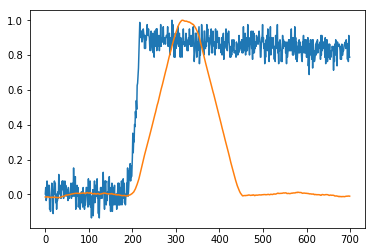

In [284]:
plt.figure()
a_signal = baseLineReduction(mysignals[100][:])
plt.plot(a_signal[800:1500]/np.amax(a_signal))
plt.plot(trap_out[100][800:1500]/np.amax(trap_out[100][:]))
print(len(trap_out[0]))
print(np.argmax(trap_out[100][:]))

In [148]:
#from scipy.interpolate import UnivariateSpline
#spline = UnivariateSpline(trap_out[100][:])

In [149]:
#print(len(trap_out[100]))
#print(FWHM(trap_out[100][:],range(len(trap_out[100]))))

In [270]:
counts = []
for j in range(0,len(trap_out)):
    counts = np.append(counts,np.amax(trap_out[j]))

<BarContainer object of 8196 artists>

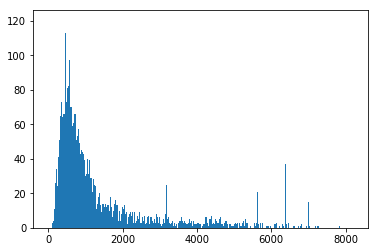

In [271]:
#print(np.trim_zeros(counts))
counts2 = np.trim_zeros(counts)
counts3 = counts2[(counts2>0) & (counts2<0.6e9)]
#plt.figure()
#nhist, bins, ign = plt.hist(counts3,bins=8196)
yhist, bins_hist = np.histogram(counts3,bins=8196)
plt.figure()
plt.bar(range(8196),yhist, width=1.0)
#fig, ax = plt.subplots()
#counts, bins, patches = ax.hist(counts3,bins=8196)
#ax.set_xticklabels(range(8196))
#plt.yscale('log')
#xhist = np.linspace(0, 8196, 8196, False)
#plt.show()

